#Comp 767 Assignment 3 Question 4
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
https://colab.research.google.com/drive/1Rbetn6BrECTLursR8MzznXkj5rSBhQZc



In [2]:
#Assignment general instructions ask for runtimes in google colab
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=b79e2c05f04f747d6d41ceab660bcbb1e78d751350711e4187c9377acd44f76a
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
#imports
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

time: 2.07 s


# REINFORCE

In [4]:
class REINFORCE_Policy(nn.Module):
    def __init__(self,hidden_layer_size):
        super(REINFORCE_Policy, self).__init__()
        #environment state to hidden layer
        self.hidden_layer = nn.Linear(4, hidden_layer_size)
        #hidden layer to output layer
        self.output_layer = nn.Linear(hidden_layer_size,2)
    def forward(self, x):
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        #compute softmax distribution over MLP output
        return F.softmax(x, dim=1)

time: 7.39 ms


In [5]:
class REINFORCE(object):

    #initialize parameters for mountain car
    def __init__(self,gamma,seed,learning_rate,hidden_layer_size):
        #torch random seed
        torch.manual_seed(seed)
        #set numpy random seed
        np.random.seed(seed)
        #gamma parameter
        self.gamma = gamma
        #initialize two layered MLP
        self.policy = REINFORCE_Policy(hidden_layer_size)
        #initalize adam optimizer
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)


    def get_action(self,s,log_prob_history):
        #with help from - https://pytorch.org/docs/stable/distributions.html
        #convert state of agent from numpy array to pytorch tensor
        s = torch.from_numpy(s).float().unsqueeze(0)
        #get the softmax distribution across actions
        p = self.policy(s)
        #create a categorical distribution
        policy_distribution = Categorical(p)
        #sample action from categorical distribution
        a = policy_distribution.sample()
        #save policy value for action taken, will be used in loss calc
        log_prob_history.append(policy_distribution.log_prob(a))
        #return action for agent
        return a.item()


    def update(self,reward_history,log_prob_history):
        #with help from - https://pytorch.org/docs/stable/optim.html
        #current return
        G = 0
        policy_loss = []
        #return history
        return_history = []
        for r in reward_history[::-1]:
            #calculate return a time t using previous return
            G = r + self.gamma * G
            #add return to the front of return history
            return_history.insert(0, G)
        #convert return history to pytorch tensor
        return_history = torch.tensor(return_history)
        #calculate policy loss at each time step
        for i in range(len(reward_history)):
            policy_loss.append(-log_prob_history[i] * return_history[i])
        #sum loss 
        policy_loss = torch.cat(policy_loss).sum()
        #zero gradient buffers of all parameters
        self.optimizer.zero_grad()
        #compute gradients
        policy_loss.backward()
        #update parameters
        self.optimizer.step()


    def train(self,env,seed,max_ep):
        #set random seed for environment
        env.seed(seed)
        #episode length data array
        data = np.zeros(max_ep)

        #run number of episodes
        for i in range(max_ep):
            #reset environment
            state = env.reset()
            #reset reward
            total_reward = 0
            #reset termination boolean
            done = False
            #reset episode reward history
            reward_history = []
            #reset episode log_prob history
            log_prob_history = []

            while not done:
                #get action from policy
                action = self.get_action(state,log_prob_history)
                #step through environment with action
                state, reward, done, _ = env.step(action)
                #update reward history
                #self.reward_history.append(reward)
                reward_history.append(reward)
                #update total reward (here reward = episode length)
                total_reward += reward

            #update parameters
            self.update(reward_history,log_prob_history)
            #In cartpole episode reward = episode length
            data[i] = total_reward

        return data

time: 76.6 ms


#Actor-Critic

In [6]:
class actor_Policy(nn.Module):
    def __init__(self,hidden_layer_size):
        super(actor_Policy, self).__init__()
        #environment state to hidden layer
        self.hidden_layer = nn.Linear(4, hidden_layer_size)
        #hidden layer to output layer
        self.output_layer = nn.Linear(hidden_layer_size,2)
    def forward(self, x):
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        #compute softmax distribution over MLP output
        return F.softmax(x, dim=1)

time: 6.21 ms


In [7]:
class critic_Value(nn.Module):
    def __init__(self,hidden_layer_size):
        super(critic_Value, self).__init__()
        #environment state to hidden layer
        self.hidden_layer2 = nn.Linear(4, hidden_layer_size)
        #hidden layer to output layer
        self.output_layer2 = nn.Linear(hidden_layer_size,1)
    def forward(self, x):
        x = self.hidden_layer2(x)
        x = F.relu(x)
        x = self.output_layer2(x)
        return x

time: 7.84 ms


In [8]:
class AC(object):

    #initialize parameters for mountain car
    def __init__(self,gamma,seed,learning_rate,hidden_layer_size):
        #torch random seed
        torch.manual_seed(seed)
        #set numpy random seed
        np.random.seed(seed)
        #gamma parameter
        self.gamma = gamma

        #initialize actor network
        self.actor_policy = actor_Policy(hidden_layer_size)
        #initalize adam optimizer
        self.actor_optimizer = optim.Adam(self.actor_policy.parameters(), lr = learning_rate)

        #initialize critic network
        self.critic_value = critic_Value(hidden_layer_size)
        #initalize adam optimizer
        self.critic_optimizer = optim.Adam(self.critic_value.parameters(), lr = learning_rate)

    #use actor policy
    def get_action(self,s):
        #with help from - https://pytorch.org/docs/stable/distributions.html
        #get the softmax distribution across actions
        p = self.actor_policy(s)
        #create a categorical distribution
        policy_distribution = Categorical(p)
        #sample action from categorical distribution
        a = policy_distribution.sample()
        #return action for agent and log prob of action
        return (a.item(), policy_distribution.log_prob(a))


    def update(self,TD_error,log_prob,I):
        #with help from - https://pytorch.org/docs/stable/optim.html 
        actor_loss = (-(I * TD_error.detach() * log_prob)).sum()
        critic_loss = -TD_error.sum()
        
        #zero gradient buffers of all parameters
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        #compute gradients
        actor_loss.backward()
        critic_loss.backward()
        #update parameters
        self.actor_optimizer.step()
        self.critic_optimizer.step()


    def train(self,env,seed,max_ep):
        #set random seed for environment
        env.seed(seed)
        #episode length data array
        data = np.zeros(max_ep)

        #run number of episodes
        for i in range(max_ep):
            #reset environment
            state = env.reset()
            #convert state of agent from numpy array to pytorch tensor
            state = torch.from_numpy(state).float().unsqueeze(0)
            #reset reward
            total_reward = 0
            #reset termination boolean
            done = False
            #discount factor rolling product
            I = 1
            #episode history 
            I_history = []
            log_prob_history = []
            TD_error_history = []

            while not done:
                #get action from policy
                action,log_prob = self.get_action(state)
                #step through environment with action
                next_state, reward, done, _ = env.step(action)
                #convert state of agent from numpy array to pytorch tensor
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                #TD error
                TD_error = reward + (self.gamma * self.critic_value(next_state)) - self.critic_value(state)

                #update total reward (equivilant to episode length)
                total_reward += reward
                #update I
                I *= self.gamma

                #update episode vectors
                I_history.append(torch.tensor([I], dtype=torch.float))
                log_prob_history.append(log_prob)
                TD_error_history.append(TD_error)

                #update state
                state = next_state

            #In cartpole episode reward = episode length
            data[i] = total_reward

            #put history vectors into one single tensor
            I_history = torch.cat(I_history)
            log_prob_history = torch.cat(log_prob_history)
            TD_error_history = torch.cat(TD_error_history)

            #update actor and critic parameters
            self.update(TD_error_history,log_prob_history,I_history)

        return data

time: 92.8 ms


#Hyperparamter Search (Learning Rate)

To select the learning rate for REINFORCE and actor-critic we tested 5 different learning rates on 1 random seed for 2000 episodes. For each algorithm we present 2 different data plots; the first is of episode length, this is the same plot as in the experiment section.  The second plot shows the average episode length, this plot gives a clear indication as to which learning rate should be selected for each algorithm.

In [19]:
env = gym.make('CartPole-v0')

#random seeds
seed = 0
MAX_epsisodes = 2000
gamma = 0.9
hidden_layer_size = 64
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]
episode_length_RE = np.zeros([len(learning_rates),MAX_epsisodes])

for i in range(len(learning_rates)):
    print('learning rate: ',learning_rates[i])
    alg = REINFORCE(gamma,seed,learning_rates[i],hidden_layer_size)
    #train and get length
    length = alg.train(env,seed,MAX_epsisodes)
    #collect length stats
    episode_length_RE[i,:] = length


learning rate:  0.1
learning rate:  0.01
learning rate:  0.001
learning rate:  0.0001
learning rate:  1e-05
time: 4min 19s


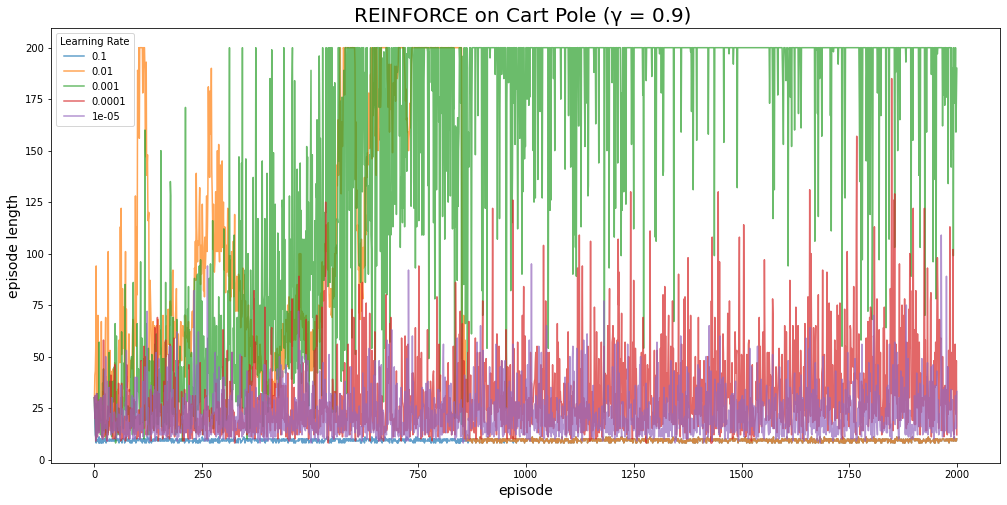

time: 348 ms


In [21]:
plt.figure(figsize=(17,8))
x = np.arange(MAX_epsisodes)

for i in range(len(learning_rates)):
    plt.plot(x,episode_length_RE[i,:],label=learning_rates[i],alpha = 0.7)
    

plt.title('REINFORCE on Cart Pole (\u03B3 = 0.9) ', fontsize=20)
plt.xlabel('episode',fontsize=14)
plt.ylabel('episode length',fontsize=14)
plt.legend(loc='upper left',title='Learning Rate')
plt.show()

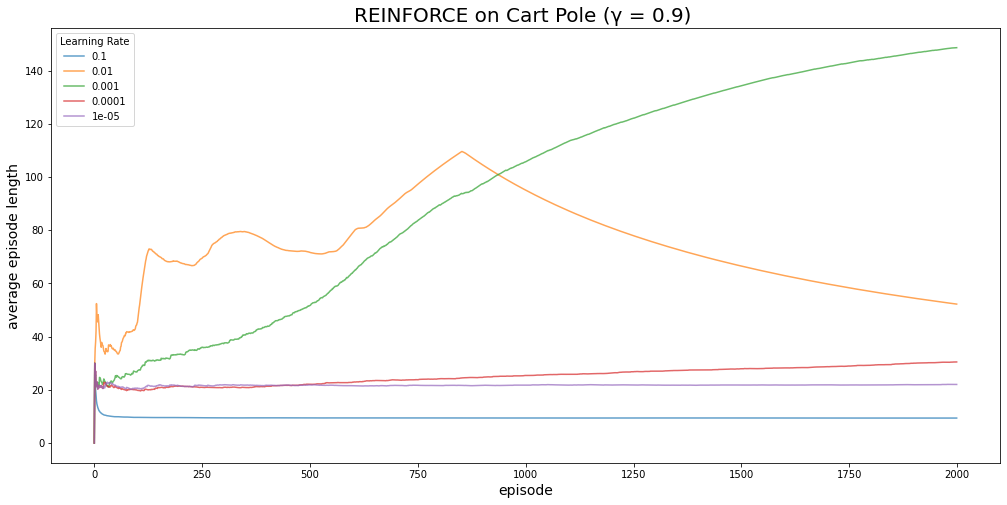

time: 369 ms


In [25]:
plt.figure(figsize=(17,8))
avg_length_RE = np.zeros([len(learning_rates),MAX_epsisodes])

for i in range(len(learning_rates)):
    for j in range(MAX_epsisodes-1):
        avg_length_RE[i,j+1] = np.mean(episode_length_RE[i,0:j+1])

for i in range(len(learning_rates)):
    plt.plot(x[0:2000],avg_length_RE[i,0:2000],label=learning_rates[i],alpha = 0.7)
    

plt.title('REINFORCE on Cart Pole (\u03B3 = 0.9) ', fontsize=20)
plt.xlabel('episode',fontsize=14)
plt.ylabel('average episode length',fontsize=14)
plt.legend(loc='upper left',title='Learning Rate')
plt.show()

###REINFORCE
Using the above plots we select the learning rate of 0.001 for training REINFORCE

In [14]:
env = gym.make('CartPole-v0')

#random seeds
seed = 0
MAX_epsisodes = 2000
gamma = 0.9
hidden_layer_size = 64
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]
episode_length_AC = np.zeros([len(learning_rates),MAX_epsisodes])

for i in range(len(learning_rates)):
    print('learning rate: ',learning_rates[i])
    alg = AC(gamma,seed,learning_rates[i],hidden_layer_size)
    #train and get length
    length = alg.train(env,seed,MAX_epsisodes)
    #collect length stats
    episode_length_AC[i,:] = length


learning rate:  0.1
learning rate:  0.01
learning rate:  0.001
learning rate:  0.0001
learning rate:  1e-05
time: 6min 13s


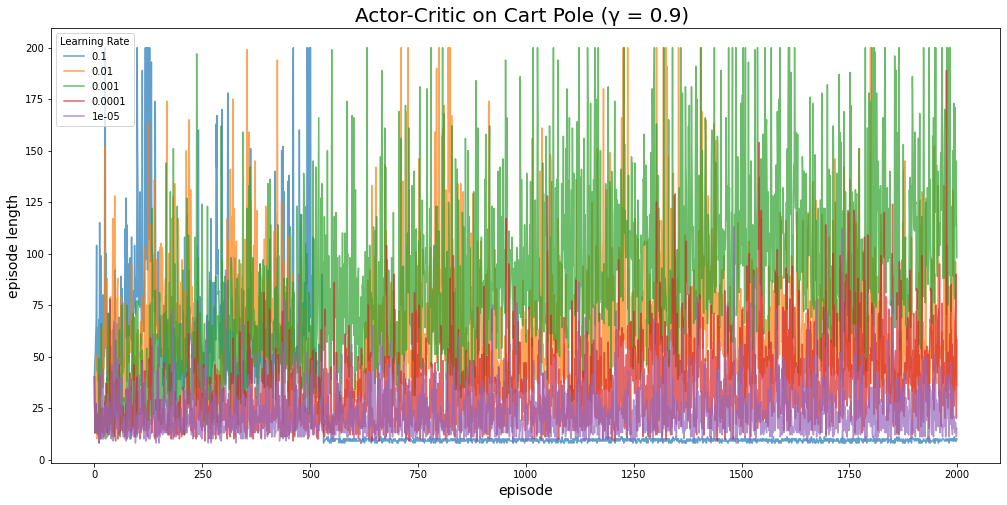

time: 407 ms


In [15]:
plt.figure(figsize=(17,8))
x = np.arange(MAX_epsisodes)

for i in range(len(learning_rates)):
    plt.plot(x,episode_length_AC[i,:],label=learning_rates[i],alpha = 0.7)
    

plt.title('Actor-Critic on Cart Pole (\u03B3 = 0.9) ', fontsize=20)
plt.xlabel('episode',fontsize=14)
plt.ylabel('episode length',fontsize=14)
plt.legend(loc='upper left',title='Learning Rate')
plt.show()

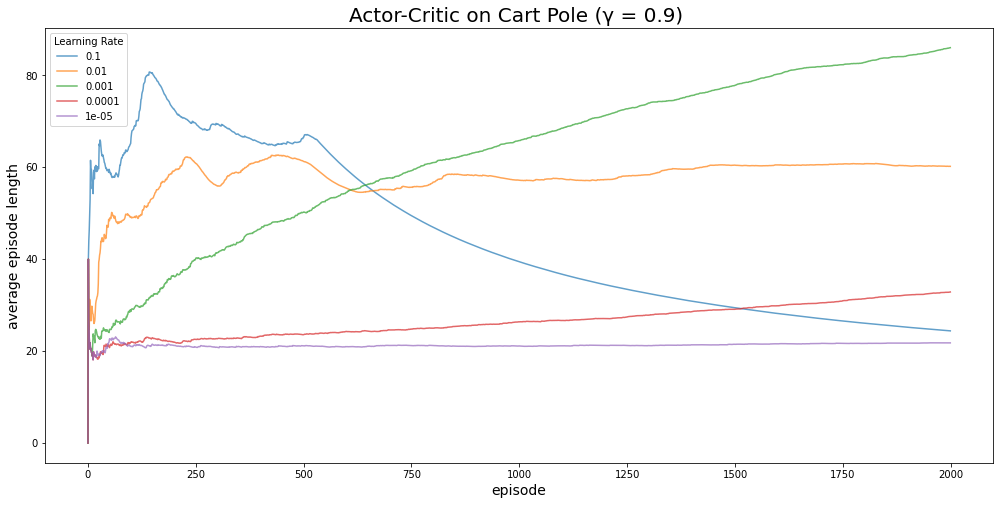

time: 346 ms


In [18]:
plt.figure(figsize=(17,8))
avg_length_AC = np.zeros([len(learning_rates),MAX_epsisodes])

for i in range(len(learning_rates)):
    for j in range(MAX_epsisodes-1):
        avg_length_AC[i,j+1] = np.mean(episode_length_AC[i,0:j+1])

for i in range(len(learning_rates)):
    plt.plot(x[0:2000],avg_length_AC[i,0:2000],label=learning_rates[i],alpha = 0.7)
    

plt.title('Actor-Critic on Cart Pole (\u03B3 = 0.9) ', fontsize=20)
plt.xlabel('episode',fontsize=14)
plt.ylabel('average episode length',fontsize=14)
plt.legend(loc='upper left',title='Learning Rate')
plt.show()

###Actor-Critic
Using the above plots we select the learning rate of 0.001 for training Actor-Critic

#Experiment Details
In this experiment we have trained 2 models, the REINFORCE algorithm and an actor-critic algorithm on the Open AI gym cartpole environment with $\gamma$ = 0.9. For the REINFORCE algorithm we have used a 2 layer MLP with a hidden layer containing 64 units, the activation function for the hidden layer was ReLU (as discussed on MyCourses). Our REINFORCE algorithm was trained using the Adam optimizer in PyTorch with a learning rate of 0.001. For the actor critic algorithm both the actor and critic were modelled with 2 layer MLP's each with a hidden layer containing 64 units, each hidden layer used the ReLU activation function. Both actor and critic were trained with the Adam optimizer in PyTorch with a learning rate of 0.001.

For the actor-critic algorithm I tried to implement the 'One-step Actor–Critic (episodic)' algorithm from the Sutton and Barto textbook page 332, the code for this implementation is at the bottom of this notebook. This algorithm updates actor and critic parameters on every step of every episode. I was unable to get this implementation to train well on the cartpole task and therefore decided to modify the algorithm slightly. This modified version is  found above in the notebook and is what was used in my experiments. Instead of updating the actor and critic parameters on every step of an episode, I calculate the bootstrapped errors online and save them in memory and only update the actor and critic parameters at the end of an episode. In this implementation we are still updating the value estimate for states from the estimated values of subsequent states (bootstrapping), therefore it is a valid actor critic method (as discussed on page 331 of the Sutton and Barto textbook). I found this made training much more stable and led to a more meaningful discussion below. I have included both implementations in this notebook.

NOTE: My colab notebook disconnected before I could submit the notebook and I did not have enough time to rerun this code block before the submission deadline. The experiment below takes roughly 1 hour and 45 minutes to run.

NOTE: In the plot below the confidence intervals are not correct. I found a mistake in my code when calculating the standard deviation of episode length. This mistake is now corrected in the code, but I did not have enough time to rerun the experiment to obtain the correct plot. I discuss the variance of REINFORCE and actor-critic methods on a more theoretical level in my discussion below to compensate.

In [0]:
env = gym.make('CartPole-v0')

#random seeds
seeds = np.arange(0,5)
MAX_epsisodes = 6000
episode_length = np.zeros([len(seeds),MAX_epsisodes])
gamma = 0.9
hidden_layer_size = 64
learning_rate = 0.001

algorithms = [REINFORCE,AC]

avg = np.zeros([2,MAX_epsisodes])
std = np.zeros([2,MAX_epsisodes])

for i in range(len(algorithms)):
    for j in range(len(seeds)):
        print('seed: ',seeds[j])
        alg = algorithms[i](gamma,seeds[j],learning_rate,hidden_layer_size)
        #train and get length
        length = alg.train(env,int(seeds[j]),MAX_epsisodes)
        #collect length stats
        episode_length[j,:] = length

    #compute mean and standard deviation statistics for parameter pair
    avg[i,:] = np.mean(episode_length,axis=0)
    std[i,:] = np.std(episode_length,axis=0)

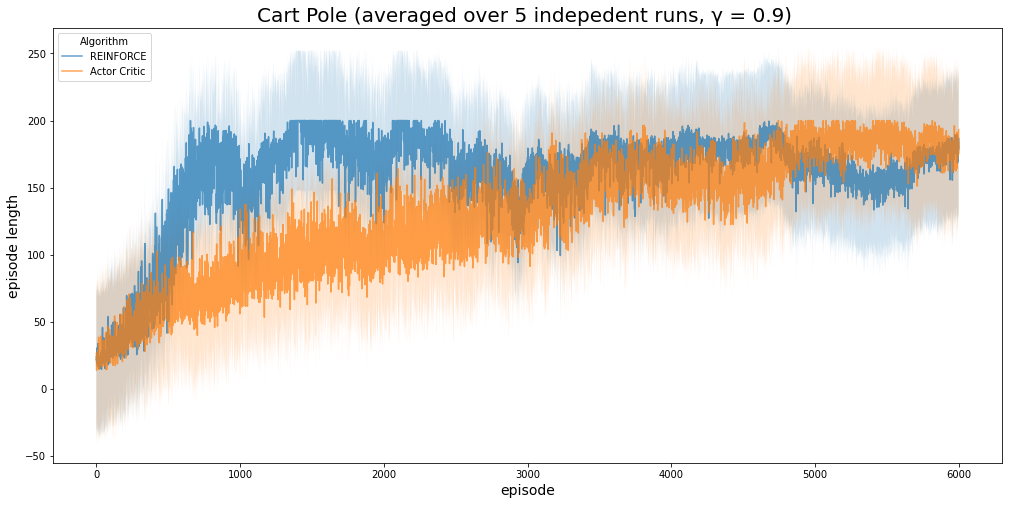

time: 381 ms


In [137]:
plt.figure(figsize=(17,8))
x = np.arange(MAX_epsisodes)
labels = ['REINFORCE','Actor Critic']

for i in range(len(algorithms)):
    plt.plot(x,avg[i,:],label=labels[i],alpha=0.7)
    plt.fill_between(x,avg[i,:]-std[i,:],avg[i,:]+std[i,:],alpha=0.2)
    

plt.title('Cart Pole (averaged over 5 indepedent runs, \u03B3 = 0.9) ', fontsize=20)
plt.xlabel('episode',fontsize=14)
plt.ylabel('episode length',fontsize=14)
plt.legend(loc='upper left',title='Algorithm')
plt.show()

#Discussion

There are two immediate observations from the chart above. Intially REINFORCE learns much faster than the actor critic algorithm, REINFORCE is able to achieve the maximum episode length of 200 steps before 1000 episodes of experience and by roughly 1500 episodes of experience is reaching 200 steps in an episode consistently. On the other hand the actor-critic algorithm learns more slowly and does not achieve a 200 step episode until nearly 4000 episodes of experience. This slower training in the actor-critic algorithm is most likely caused by the fact that both the actor and critic need to be trained simultaneously where as in REINFORCE only the policy network (actor) needs to be trained.

The second obversation is that the improvement of the actor-critic algorithm during training is much more stable than the REINFORCE algorithm. Although learning very fast, the REINFORCE algorithm sees a drop in performance after roughly 3000 episodes of experience and struggles to regain the performance it once had around 1500 episodes of experience. A similar drop in performance can be seen after about 1000 episodes of experience. The actor-critic algorithm is much more consistent and constantly improves during the 6000 episodes and appears to surpass REINFORCE around the 4800 episode mark.

As discussed in the Sutton and Barto textbook, as a Monte Carlo method REINFORCE can be of high variance, which I believe is what we observe as the drop in performance around episodes 1000 and 3000. The textbook discussed that this variance can be reduced by REINFORCE with baseline, which compares the return $G_t$ with a state value estimate $V(S_t,w)$. The textbook also reiterates that Monte Carlo methods are inconvienent to implement online and for continuous problems. This motivates the concept of a critic that can be used to estimate one step returns and transform REINFORCE with baseline into an online actor-critic method that is also of lower varaince than REINFORCE. As discussed above my implementation for the experiments calculates the one step returns online but only updates parameters at the end of an episode. If one wanted to use this method for a continuous problem you could simply select a batch size $n$ and update the parameters after every $n$ steps of experience.

#One Step Actor-Critic (Sutton and Barto Pg. 332)
Included for reference

In [109]:
class AC(object):

    #initialize parameters for mountain car
    def __init__(self,gamma,seed,learning_rate,hidden_layer_size):
        #torch random seed
        torch.manual_seed(seed)
        #set numpy random seed
        np.random.seed(seed)
        #gamma parameter
        self.gamma = gamma

        #initialize actor network
        self.actor_policy = actor_Policy(hidden_layer_size)
        #initalize adam optimizer
        self.actor_optimizer = optim.Adam(self.actor_policy.parameters(), lr = learning_rate/10.0)

        #initialize critic network
        self.critic_value = critic_Value(hidden_layer_size)
        #initalize adam optimizer
        self.critic_optimizer = optim.Adam(self.critic_value.parameters(), lr = learning_rate)

    #use actor policy
    def get_action(self,s):
        #with help from - https://pytorch.org/docs/stable/distributions.html
        #get the softmax distribution across actions
        p = self.actor_policy(s)
        #create a categorical distribution
        policy_distribution = Categorical(p)
        #sample action from categorical distribution
        a = policy_distribution.sample()
        #return action for agent and log prob of action
        return (a.item(), policy_distribution.log_prob(a))


    def update(self,state,TD_error,action,log_prob,I):
        #with help from - https://pytorch.org/docs/stable/optim.html 
        actor_loss = -(I * TD_error.detach() * log_prob)
        critic_loss = -TD_error
        
        #zero gradient buffers of all parameters
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        #compute gradients
        actor_loss.backward()
        critic_loss.backward()
        #update parameters
        self.actor_optimizer.step()
        self.critic_optimizer.step()


    def train(self,env,seed,max_ep):
        #set random seed for environment
        env.seed(seed)
        #episode length data array
        data = np.zeros(max_ep)

        #run number of episodes
        for i in range(max_ep):
            #reset environment
            state = env.reset()
            #convert state of agent from numpy array to pytorch tensor
            state = torch.from_numpy(state).float().unsqueeze(0)
            #reset reward
            total_reward = 0
            #reset termination boolean
            done = False
            #discount factor rolling product
            I = 1

            while not done:
                #get action from policy
                action,log_prob = self.get_action(state)
                #step through environment with action
                next_state, reward, done, _ = env.step(action)
                #convert state of agent from numpy array to pytorch tensor
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                #TD error
                TD_error = reward + (self.gamma * self.critic_value(next_state)) - self.critic_value(state)
            
                #update all weights
                self.update(state,TD_error,action,log_prob,I)
                #Update episode reward
                total_reward += reward
                #update I
                I *= self.gamma
                #update state
                state = next_state

            #In cartpole episode reward = episode length
            data[i] = total_reward

        return data

time: 84.1 ms
